In [1]:
import warnings
warnings.filterwarnings('ignore')

from astropy.table import Table, hstack, vstack, join, MaskedColumn
import numpy as np
import matplotlib.pyplot as plt
import astropy.constants as ac
import astropy.units as au
from glob import glob
from spectral_cube import SpectralCube
import scipy 
from reproject import reproject_interp
from scipy.optimize import curve_fit

from tqdm.auto import tqdm 
from astropy.io import fits
import matplotlib as mpl
import pyregion
import aplpy
import math
import os
import pickle

plt.style.use('paper')

In [2]:
"""Easy pickel"""

def save_pickle(a, filename): 
    with open(filename, 'wb') as handle:
        pickle.dump(a, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print('[INFO] Saved to %s' %filename)
    return()

def load_pickle(filename):
    with open('%s'%filename, 'rb') as handle:
        b = pickle.load(handle)
    print('[INFO] Load %s' %filename)
    return(b)

In [3]:
def find_nearest(array, value):
    """find nearest value in array, and return id"""
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx], idx

In [4]:
"""Load properties of the hst nebula catalouge"""
props_all = Table.read('../../analysis/dendro/props_all/props_all_2.fits')
n = len(props_all)

In [5]:
def correct_ha_flux(flux_ha, ebv):
    # Corrects the H-alpha flux by the extinction value (EBV)
    
    # Extinction coefficient for H-alpha (assuming R_V = 3.1)
    extinction_coefficient = 2.5 * 1.086
    
    # Calculate the correction factor
    correction_factor = 10 ** (extinction_coefficient * ebv)
    
    # Apply the correction to the H-alpha flux
    corrected_flux_ha = flux_ha * correction_factor
    
    return corrected_flux_ha

def calculate_luminosity(flux_ha, ebv, distance):
    # Calculates the bolometric luminosity from H-alpha flux
    
    # Correct H-alpha flux for extinction
    corrected_flux_ha = correct_ha_flux(flux_ha.quantity, ebv.quantity.value)
    
    # Convert H-alpha flux to luminosity
    luminosity_ha = 4 * np.pi * (distance.quantity ** 2) * corrected_flux_ha
    
    return luminosity_ha.to('erg/s')

props_all['flux'].unit = props_all['HA6562_FLUX'].unit
props_all['ha_lum_hst'] = calculate_luminosity(props_all['flux']*1e-20, props_all['EBV'], props_all['dist_pc'])

In [6]:
def get_SB99models(inputdir='/Users/abarnes/Dropbox/work/Projects/pressures/phangs/data/sb99/fiducial/fiducial_6p0linear/', tmin = 0, tmax = 1e8):
    
    """Get SB99 models"""

    t_ewidth = Table.read('%s/fiducial_6p0linear.ewidth1' %(inputdir), format='ascii', header_start=3, data_start=4)
    names = ['TIME', 'QHI', 'QHIf', 'QHeI', 'QHeIf', 'QHeII', 'QHeIIf', 'logL']
    t_quanta = Table.read('%s/fiducial_6p0linear.quanta1' %(inputdir), format='ascii', data_start=5, names=names)
    names = ['TIME', 'ALLp', 'OBp', 'RSGp', 'LBVp', 'WRp', 'ALLe', 'ALLm', 'OBm', 'RSGm', 'LBVm', 'WRm']
    t_power = Table.read('%s/fiducial_6p0linear.power1' %(inputdir), format='ascii', data_start=5, names=names)
    names = ['TIME', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'Mdotwind', 'Mdotsne','Mdotboth', 'Mtot']
    t_yield = Table.read('%s/fiducial_6p0linear.yield1' %(inputdir), format='ascii', data_start=5, names=names)

    time = t_ewidth['TIME']
    mask = ((time>=tmin) & (time<=tmax))
    time = time[mask]*au.yr

    Q = t_quanta['QHI'][mask]
    Mdot = t_yield['Mdotwind'][mask]
    Lmech = t_power['ALLp'][mask]
    Lbol = t_quanta['logL'][mask]
    LHa = t_ewidth['LUM(H_A)'][mask]
    Lfrac = 10**(t_quanta['logL'][mask]-t_ewidth['LUM(H_A)'][mask])
    
    return({'time':time, 'mdot':Mdot, 'lmech':Lmech, 'lbol':Lbol, 'lha':LHa, 'lfrac':Lfrac})

SB99models = get_SB99models()

In [7]:
def get_SB99models_arr(inputdir_='/Users/abarnes/Dropbox/work/Projects/pressures/phangs/data/sb99/fiducial/'):

    masses = ['4p0', '4p5', '5p0', '5p5', '6p0', '6p5']
    masses_ = [1e4, 5e4, 1e5, 5e5, 1e6, 5e6]
    n = len(masses)

    t_ewidth = dict.fromkeys(masses)
    t_quanta = dict.fromkeys(masses)
    t_power = dict.fromkeys(masses)
    t_yield = dict.fromkeys(masses)

    for mass, mass_,i in zip(masses, masses_, range(n)):


        inputdir = '%s/fiducial_%s' %(inputdir_, mass) 

        t_ewidth_ = Table.read('%s/fiducial_%s.ewidth1' %(inputdir, mass), format='ascii', header_start=3, data_start=4)

        names = ['TIME', 'QHI', 'QHIf', 'QHeI', 'QHeIf', 'QHeII', 'QHeIIf', 'logL']
        t_quanta_ = Table.read('%s/fiducial_%s.quanta1' %(inputdir, mass), format='ascii', data_start=5, names=names)

        names = ['TIME', 'ALLp', 'OBp', 'RSGp', 'LBVp', 'WRp', 'ALLe', 'ALLm', 'OBm', 'RSGm', 'LBVm', 'WRm']
        t_power_ = Table.read('%s/fiducial_%s.power1' %(inputdir, mass), format='ascii', data_start=5, names=names)

        names = ['TIME', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'Mdotwind', 'Mdotsne','Mdotboth', 'Mtot']
        t_yield_ = Table.read('%s/fiducial_%s.yield1' %(inputdir, mass), format='ascii', data_start=5, names=names)

        t_ewidth_['TIME'] = np.log10(t_ewidth_['TIME'])
        t_quanta_['TIME'] = np.log10(t_quanta_['TIME'])
        t_power_['TIME'] = np.log10(t_power_['TIME'])
        t_yield_['TIME'] = np.log10(t_yield_['TIME'])

        t_ewidth_['MASS'] = np.array([mass_]*len(t_power_['TIME']))
        t_quanta_['MASS'] = np.array([mass_]*len(t_power_['TIME']))
        t_power_['MASS'] = np.array([mass_]*len(t_power_['TIME']))
        t_yield_['MASS'] = np.array([mass_]*len(t_power_['TIME']))

        if i == 0: 
            mass_arr = t_ewidth_['MASS']
            time_arr = t_ewidth_['TIME']
            mdot_arr = t_yield_['Mdotwind']
            lmec_arr = t_power_['ALLp']
        else: 
            mass_arr = np.vstack([mass_arr,t_ewidth_['MASS']])
            time_arr = np.vstack([time_arr,t_ewidth_['TIME']])
            mdot_arr = np.vstack([mdot_arr,t_yield_['Mdotwind']]) 
            lmec_arr = np.vstack([lmec_arr,t_power_['ALLp']]) 

    mass_arr = np.log10(mass_arr)
    
    return({'mass':mass_arr, 'time':time_arr, 'mdot':mdot_arr, 'lmec':lmec_arr})

SB99models_arr = get_SB99models_arr()

In [8]:
#### Defines

age = props_all['reg_dolflux_Age_MinChiSq'].quantity.to('yr')
mass = props_all['reg_dolflux_Mass_MinChiSq'].quantity.to('Msun')
lha = props_all['ha_lum_hst']
te = props_all['T_N2_REFIT']*au.K
te[np.isnan(te)] = 8000*au.K
ne = props_all['ne']
radius = props_all['mean_sigma_pc']

lfrac = np.empty(n) *np.nan

In [9]:
# Get Lfrac 

for regionID in tqdm(range(n)):
    
    _, mask = find_nearest(SB99models['time'].value, age[regionID].value)
    lfrac[regionID] = SB99models['lfrac'][mask]
    
props_all['lbol/lha'] = lfrac *au.dimensionless_unscaled
####

#### -- plot
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot()

ax.plot(SB99models['time'].to('Myr'), np.log10(SB99models['lfrac']))

ax.scatter(age.to('Myr')+np.random.normal(size=len(age))*au.Myr*0.1, 
           np.log10(lfrac)+np.random.normal(size=len(age))*0.05, 
           c=lfrac, zorder=10, cmap='jet', s=10)

ax.set_xlim([0,20])

ax.set_xlabel('time (Myr)')
ax.set_ylabel('log(Lbol/Lha)')

ax.grid(alpha=0.3, linestyle=':')
plt.close('all')

  0%|          | 0/26 [00:00<?, ?it/s]

In [10]:
# Get Lbol 

def get_lbol(lha, conv=17.684):
    """Convert Lhalpha luminoisty to Lbolometric luminosity
        conv = 138: Taken from Kennicutt & Evans (2012) - Lopez et al. (2014)
        conv = 17.684"""
    lbol=conv*lha
    return lbol

lbol = get_lbol(lha.quantity, conv=props_all['lbol/lha'].quantity.value)
# lbol_const = get_lbol(lha.quantity, conv=88.2) #with constant conversion from Barnes21
lbol_const = get_lbol(lha.quantity, conv=138.0) #with constant conversion from Barnes21

In [11]:
### Get PDIR

def get_pdir(lbol, radius):
    """Convert bolometric luminoisty to direct radiation pressure
        Taken from Lopez et al. (2014)"""
    pdir = (3 * lbol.to('Lsun')) / (4*np.pi * (radius.to('cm')**2) * ac.c.to('cm/s') ) / ac.k_B
    return pdir.to('K/cm^3')

pdir = get_pdir(lbol, radius)
pdir_const = get_pdir(lbol_const, radius)

props_all['pdir'] = np.log10(pdir.value) * pdir.unit
props_all['pdir_const'] = np.log10(pdir_const.value) * pdir.unit

props_all['lbol'] = lbol
props_all['lbol_const'] = lbol_const

# TESTING

In [12]:
t_mcload21 = Table.read('/Users/abarnes/Dropbox/work/Smallprojects/galaxies/stellar_feedback/data/literature/McLeod2021_ngc300/McLeod2021_ngc300.fits')
t_barnes21 = Table.read('/Users/abarnes/Dropbox/work/Projects/pressures/phangs/data/catalouge/v2/physprops/master.fits') 
t_barnes21_nomask = Table.read('/Users/abarnes/Dropbox/work/Projects/pressures/phangs/data/catalouge/v2/physprops/master_notmasked.fits') 

# t_dellabruna22 = Table.read('./../../data/literature/DellaBruna2022_m83/DellaBruna2022_m83.fits')

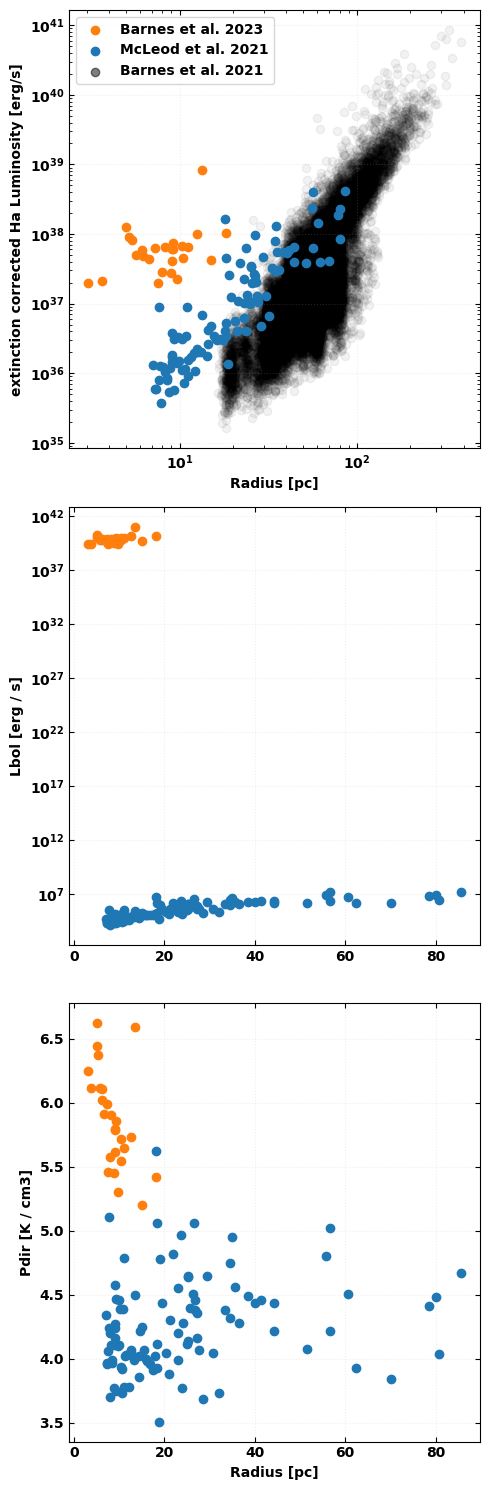

In [13]:
import matplotlib.pyplot as plt

def get_lbol(pdir, radius):
    """Convert direct radiation pressure to bolometric luminosity"""
    lbol = (pdir * ac.k_B * 4 * np.pi * (radius.to('cm') ** 2) * ac.c.to('cm/s')) / 3
    return lbol.to('Lsun')

# Create a figure with four subplots in two rows
fig, axs = plt.subplots(3, 1, figsize=(5, 15))

# Second subplot
axs[0].scatter(props_all['mean_sigma_pc'], props_all['ha_lum_hst'].to('erg/s'), label='Barnes et al. 2023', c='C1')
axs[0].scatter(t_mcload21['radius'], get_lbol(10**(t_mcload21['pdir'].quantity.value) * pdir.unit, t_mcload21['radius']).to('erg/s')/138.0, label='McLeod et al. 2021', c='C0')
axs[0].scatter(t_barnes21_nomask['reff_pc'], t_barnes21_nomask['ha_lum'].to('erg/s'),  c='black', alpha=0.05, zorder=-1)
axs[0].scatter(t_barnes21_nomask['reff_pc'][0], t_barnes21_nomask['ha_lum'].to('erg/s')[0],  c='black', label='Barnes et al. 2021', alpha=0.5, zorder=-1)

# axs[0].scatter(t_barnes21_nomask['reff_pc'], t_barnes21_nomask['ha_lum'].to('erg/s'),  c='black', label='Barnes et al. 2021', alpha=0.2, zorder=-1)
# axs[0].scatter(t_barnes21['rmin_pc'],  t_barnes21['ha_lum'].to('erg/s'), c='grey', label='Barnes et al. 2021', alpha=0.2, zorder=-1)

axs[0].set_ylabel('extinction corrected Ha Luminosity [erg/s]')
axs[0].set_xlabel('Radius [pc]')
axs[0].set_yscale('log')
axs[0].set_xscale('log')
axs[0].legend()

# Third subplot
axs[1].scatter(t_mcload21['radius'], get_lbol(10**(t_mcload21['pdir'].quantity.value) * pdir.unit, t_mcload21['radius']), label='McLeod et al. 2021', c='C0')
axs[1].scatter(props_all['mean_sigma_pc'], props_all['lbol_const'], label='Barnes et al. 2023', c='C1')
axs[1].set_ylabel('Lbol [%s]' %props_all['lbol_const'].unit)
axs[1].set_yscale('log')
# axs[2].legend()

# Fourth subplot
axs[2].scatter(t_mcload21['radius'], t_mcload21['pdir'], label='McLeod et al. 2021', c='C0')
axs[2].scatter(props_all['mean_sigma_pc'], props_all['pdir_const'], label='Barnes et al. 2023', c='C1')

axs[2].set_xlabel('Radius [pc]')
axs[2].set_ylabel('Pdir [%s]' %t_mcload21['pdir'].unit)
# axs[3].legend()

axs[0].grid()
axs[1].grid()
axs[2].grid()

# Adjust spacing between subplots
plt.tight_layout()

# Display the figure
plt.show()

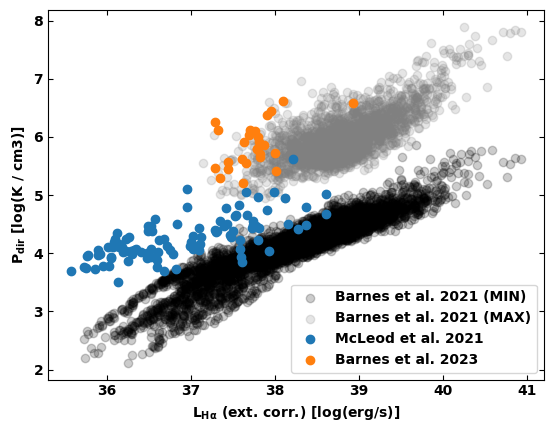

In [14]:
plt.scatter(t_barnes21['ha_lum'].to('dex(erg/s)'), t_barnes21['pdir_min'], c='black', label='Barnes et al. 2021 (MIN)', alpha=0.2)
plt.scatter(t_barnes21['ha_lum'].to('dex(erg/s)'), t_barnes21['pdir_max'], c='grey', label='Barnes et al. 2021 (MAX)', alpha=0.2)

plt.scatter(np.log10(get_lbol(10**(t_mcload21['pdir'].quantity.value) * pdir.unit, t_mcload21['radius']).to('erg/s').value/138.0), t_mcload21['pdir'], label='McLeod et al. 2021', c='C0')
# plt.scatter(props_all['ha_lum_hst'].to('dex(erg/s)'), props_all['pdir'], label='Barnes et al. 2023', c='C1')
plt.scatter(props_all['ha_lum_hst'].to('dex(erg/s)'), props_all['pdir_const'], label='Barnes et al. 2023', c='C1')

plt.xlabel(r'L$_\mathrm{H\alpha}$ (ext. corr.) [log(erg/s)]')
plt.ylabel(r'P$_\mathrm{dir}$ [log(%s)]' %t_mcload21['pdir'].unit)
plt.legend(loc='lower right')